#Load, name, and extract files from dataset

In [ ]:
# This allows to choose a file to upload
from google.colab import files

uploaded = files.upload()


Saving csv.zip to csv.zip


In [ ]:
import zipfile
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'csv.zip' with the actual filename of your ZIP
zip_file = "csv.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("nba_data")  # There are a lot of files within the CSV so this extracts them all

# Check the extracted files
os.listdir("nba_data")




['common_player_info.csv',
 'team_info_common.csv',
 'game_info.csv',
 'draft_history.csv',
 'play_by_play.csv',
 'line_score.csv',
 'officials.csv',
 'other_stats.csv',
 'draft_combine_stats.csv',
 'game.csv',
 'team_details.csv',
 'team_history.csv',
 'game_summary.csv',
 'inactive_players.csv',
 'player.csv',
 'team.csv']

In [ ]:


#Name the folder where the CSV files were extracted
data_path = "nba_data"


In [ ]:
#load datasets required for analysis.
games_df = pd.read_csv(os.path.join(data_path, "game.csv"))
line_scores_df = pd.read_csv(os.path.join(data_path, "line_score.csv"))
game_info_df = pd.read_csv(os.path.join(data_path, "game_info.csv"))
game_summary_df = pd.read_csv(os.path.join(data_path, "game_summary.csv"))
teams_df = pd.read_csv(os.path.join(data_path, "team.csv"))
team_info_df = pd.read_csv(os.path.join(data_path, "team_info_common.csv"))

print("Games:", len(games_df))
print("Line Scores:", len(line_scores_df))
print("Game Info:", len(game_info_df))
print("Game Summary:", len(game_summary_df))
print("Teams:", len(teams_df))


Games: 65698
Line Scores: 58053
Game Info: 58053
Game Summary: 58110
Teams: 30


In [ ]:
#columns in the 'games' dataset
print(games_df.columns)


Index(['season_id', 'team_id_home', 'team_abbreviation_home', 'team_name_home',
       'game_id', 'game_date', 'matchup_home', 'wl_home', 'min', 'fgm_home',
       'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home', 'fg3_pct_home',
       'ftm_home', 'fta_home', 'ft_pct_home', 'oreb_home', 'dreb_home',
       'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pf_home',
       'pts_home', 'plus_minus_home', 'video_available_home', 'team_id_away',
       'team_abbreviation_away', 'team_name_away', 'matchup_away', 'wl_away',
       'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away',
       'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away',
       'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away',
       'pf_away', 'pts_away', 'plus_minus_away', 'video_available_away',
       'season_type'],
      dtype='object')


In [ ]:
#columns in the 'game summary' dataset
print(game_summary_df.columns)

Index(['game_date_est', 'game_sequence', 'game_id', 'game_status_id',
       'game_status_text', 'gamecode', 'home_team_id', 'visitor_team_id',
       'season', 'live_period', 'live_pc_time',
       'natl_tv_broadcaster_abbreviation', 'live_period_time_bcast',
       'wh_status'],
      dtype='object')


#Standardize and merge data

In [ ]:
# Standardize date columns for consistent merging, by changing the date and time format
games_df["game_date"] = pd.to_datetime(games_df["game_date"], errors="coerce")
game_info_df["game_date"] = pd.to_datetime(game_info_df["game_date"], errors="coerce")
game_summary_df["game_date_est"] = pd.to_datetime(game_summary_df["game_date_est"], errors="coerce")


In [ ]:
#Start merging the datasets
#(Gamesdf + linescoresdf)
merged_df = pd.merge(
    games_df,
    line_scores_df,
    on="game_id",
    how="left",
    suffixes=("", "_line")
)

# + game info (attendance, time)
merged_df = pd.merge(
    merged_df,
    game_info_df[["game_id", "attendance", "game_time"]],
    on="game_id",
    how="left"
)

# + game summary (box score stats & outcomes...)
game_summary_keep = [
    "game_id", "game_date_est", "game_status_text", "season", "live_period", "live_pc_time",
    "natl_tv_broadcaster_abbreviation", "live_period_time_bcast", "wh_status", "home_team_id", "visitor_team_id"
]

merged_df = pd.merge(
    merged_df,
    game_summary_df[game_summary_keep],
    on="game_id",
    how="left",
    suffixes=('', '_summary')
)

In [ ]:
# Merge home team data: attach team info
merged_df = pd.merge(
    merged_df,
    teams_df.add_suffix("_home"),
    left_on="home_team_id",
    right_on="id_home",
    how="left"
)

# Merge away team data: attach team info for the away team
merged_df = pd.merge(
    merged_df,
    teams_df.add_suffix("_away"),
    left_on="visitor_team_id",
    right_on="id_away",
    how="left"
)

## Check for missing or NA values

In [ ]:
# Check for missing or NA values
master_df.isna().sum()

missing_summary = master_df.isna().sum().reset_index()
missing_summary.columns = ['Column', 'Missing Values']
print(missing_summary)



                    Column  Missing Values
0                  game_id               0
1            game_date_est            7629
2              season_year               0
3              season_type               0
4             home_team_id            7621
5           team_name_home               0
6          visitor_team_id            7621
7           team_name_away               0
8                 pts_home               0
9                 pts_away               0
10              point_diff               0
11                home_win               0
12              attendance           12979
13               game_time           35714
14  team_abbreviation_home               0
15  team_abbreviation_away               0
16          home_rest_days               0
17          away_rest_days               0
18       home_back_to_back               0
19       away_back_to_back               0
20     home_winpct_pregame               0
21           away_team_win               0
22     away

In [ ]:
#Gives percent of missing values for each column
(master_df.isna().mean() * 100).round(2)

#*Travel distance missing is okay because we have not created that value yet


,0
game_id,0.00
game_date_est,11.62
season_year,0.00
season_type,0.00
home_team_id,11.61
team_name_home,0.00
visitor_team_id,11.61
team_name_away,0.00
pts_home,0.00
pts_away,0.00


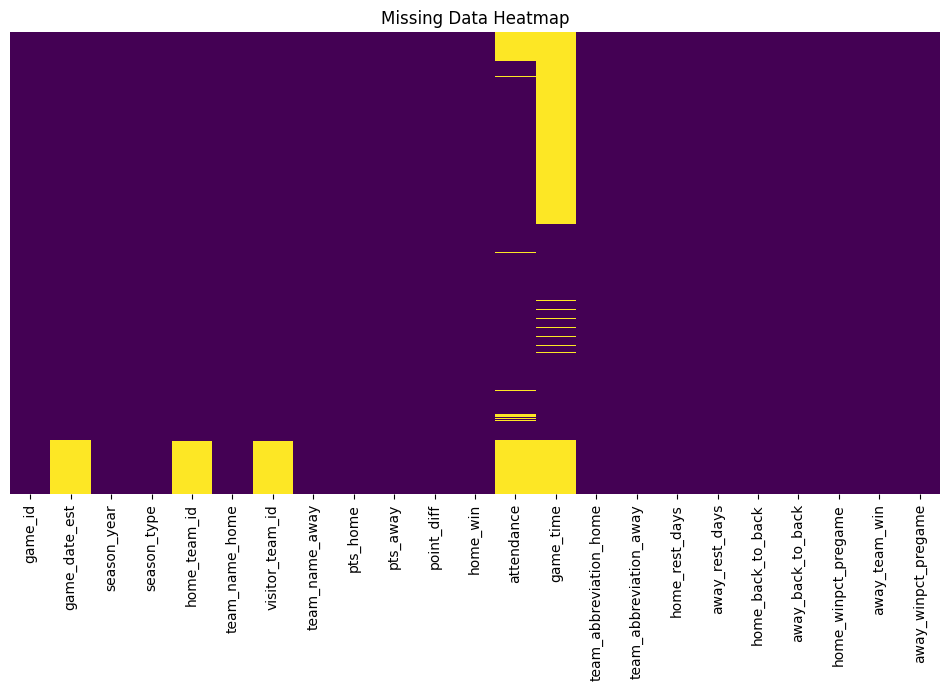

In [ ]:

# Visualize missing values as a heatmap
plt.figure(figsize=(12,6))
sns.heatmap(master_df.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()


In [ ]:
#****Needs work***
#Is the lack of attendance data due to COVID?
#Lets see:
# Create a flag for missing attendance
master_df['attendance_missing'] = master_df['attendance'].isna()

# Group by season_year and calculate % missing
attendance_missing_by_season = master_df.groupby('season_year')['attendance_missing'].mean() * 100

# Sort by season_year for clarity
attendance_missing_by_season = attendance_missing_by_season.sort_index()

# Display the results
print(attendance_missing_by_season)

season_year
1200     23.716814
1201      9.414758
1202     37.837838
1946     99.697885
1947    100.000000
           ...    
4198     22.395023
4199     11.623246
4200     11.719939
4201     19.350962
4202      6.640625
Name: attendance_missing, Length: 90, dtype: float64


In [ ]:
print(master_df['season_year'].unique())


[1946 4194 1947 1948 1949 1950 3195 4195 1951 1952 1953 1954 1955 1956
 1957 1958 1959 3196 4196 1962 1963 1964 1965 1967 1968 1969 3197 4197
 1971 1972 1973 1974 1977 1978 1979 1980 3198 4198 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 3199 4199 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 3200 4200 2001 2002 2003 2004 1200 2005 2006 2007
 2008 2009 1201 2010 3201 4201 2011 2013 2014 2015 2016 2017 2018 2019
 1202 2020 3202 4202 2021 2022]


In [ ]:
print(master_df['attendance'])

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
66198   NaN
66206   NaN
66209   NaN
66225   NaN
66253   NaN
Name: attendance, Length: 65642, dtype: float64


In [ ]:
# Count of missing values in the attendance column
missing_attendance = master_df['attendance'].isna().sum()

# Total number of rows in the dataset
total_rows = len(master_df)

print(f"Missing attendance values: {missing_attendance} out of {total_rows} total rows")
print(f"Percentage missing: {missing_attendance / total_rows * 100:.2f}%")


Missing attendance values: 12979 out of 65642 total rows
Percentage missing: 19.77%


###Shows that a lot of our missing attendance data is in 2020/2021

In [ ]:
# Ensure game_date_est is datetime
master_df['game_date_est'] = pd.to_datetime(master_df['game_date_est'], errors='coerce')

# Extract year if not already done
master_df['year'] = master_df['game_date_est'].dt.year

# Filter for years 2014 through 2025
filtered_df = master_df[(master_df['year'] >= 2014) & (master_df['year'] <= 2025)]

# Group missing attendance by year within that range
missing_attendance_by_year = (
    filtered_df[filtered_df['attendance'].isna()]
    .groupby('year')
    .size()
    .sort_index()
)

print("Missing attendance counts by year (2014–2025):")
print(missing_attendance_by_year)





Missing attendance counts by year (2014–2025):
year
2016.0      2
2017.0     12
2019.0      2
2020.0    253
2021.0    510
2022.0     14
2023.0      5
dtype: int64


#Create new fields

##Create Point Differential

In [ ]:
# Create 'point diff' by subtracting points won by away team from points won home team
# If "point_diff" is negative: away team won
# If "point_diff" is positive: home team won
merged_df["point_diff"] = merged_df["pts_home"] - merged_df["pts_away"]
merged_df["home_win"] = (merged_df["point_diff"] > 0).astype(int)



##Create Clean 4 Digit Year

In [ ]:
# Creates a clean, 4 digit season year value
def parse_season_id(season_val):
    if pd.isna(season_val):
        return None
    s = str(season_val)
    if len(s) == 5 and s.startswith("2"):  # e.g., 22020 → 2020
        return int(s[1:])
    else:
        return int(s[:4])  # fallback
# season_year is the new, clean column for season year
merged_df["season_year"] = merged_df["season_id"].apply(parse_season_id)

In [ ]:
#Pick the specific columns to keep from the big merged file
master_columns = [
    "game_id", "game_date_est", "season_year", "season_type",
    "home_team_id", "team_name_home", "visitor_team_id", "team_name_away",
    "pts_home", "pts_away", "point_diff", "home_win",
    "attendance", "game_time",
    "team_abbreviation_home", "team_abbreviation_away"
]
# Take the columns listed under 'master_columns'and put into 'master_df'
# This takes away any duplicate rows within master_columns
master_df = merged_df[master_columns].drop_duplicates(subset=["game_id"])

# Sort by game date for convenience
master_df = master_df.sort_values(by="game_date_est")

# Quick check
print(master_df.head())
print(f"Master dataset created with {len(master_df):,} games")

    game_id        game_date_est  season_year     season_type  home_team_id  \
0  24600001  1946-11-01 00:00:00         1946  Regular Season  1.610610e+09   
1  24600003  1946-11-02 00:00:00         1946  Regular Season  1.610610e+09   
2  24600002  1946-11-02 00:00:00         1946  Regular Season  1.610610e+09   
3  24600004  1946-11-02 00:00:00         1946  Regular Season  1.610610e+09   
4  24600005  1946-11-02 00:00:00         1946  Regular Season  1.610610e+09   

            team_name_home  visitor_team_id       team_name_away  pts_home  \
0          Toronto Huskies     1.610613e+09      New York Knicks      66.0   
1        St. Louis Bombers     1.610610e+09   Pittsburgh Ironmen      56.0   
2  Providence Steamrollers     1.610613e+09       Boston Celtics      59.0   
3            Chicago Stags     1.610613e+09      New York Knicks      63.0   
4          Detroit Falcons     1.610610e+09  Washington Capitols      33.0   

   pts_away  point_diff  home_win  attendance game_time 

In [ ]:
#Check for duplicate game IDs to make sure we are not double dipping on a certain game
master_df["game_id"].duplicated().sum()


np.int64(0)

In [ ]:
#We are GOOD! Value is zero, because we dropped duplicates previously ^

In [ ]:
master_df.to_csv("nba_master_dataset.csv", index=False)

In [ ]:
print(master_df.columns)

Index(['game_id', 'game_date_est', 'season_year', 'season_type',
       'home_team_id', 'team_name_home', 'visitor_team_id', 'team_name_away',
       'pts_home', 'pts_away', 'point_diff', 'home_win', 'attendance',
       'game_time', 'team_abbreviation_home', 'team_abbreviation_away'],
      dtype='object')


In [ ]:
# Make sure game_date_est is datetime
master_df["game_date_est"] = pd.to_datetime(master_df["game_date_est"])

# Sort by team and date (for home and away separately)
master_df = master_df.sort_values(by=["home_team_id", "game_date_est"])


##Create Home Team Rest Days + Away Team Rest Days

In [ ]:

# Ensure dates are datetime
master_df["game_date_est"] = pd.to_datetime(master_df["game_date_est"], errors="coerce")

# Sort by team and date to make .diff() accurate
master_df = master_df.sort_values(by=["home_team_id", "game_date_est"])

# Calculate home rest days
master_df["home_rest_days"] = (
    master_df.groupby("home_team_id")["game_date_est"]
    .diff()
    .dt.days
)

# Now for away teams — must also be sorted by visitor ID and date
master_df = master_df.sort_values(by=["visitor_team_id", "game_date_est"])

master_df["away_rest_days"] = (
    master_df.groupby("visitor_team_id")["game_date_est"]
    .diff()
    .dt.days
)

# Clean the results — clip negative or extreme values
master_df["home_rest_days"] = master_df["home_rest_days"].clip(lower=0, upper=10).fillna(7)
master_df["away_rest_days"] = master_df["away_rest_days"].clip(lower=0, upper=10).fillna(7)

# Quick  check
print(master_df[["home_rest_days", "away_rest_days"]].describe())


       home_rest_days  away_rest_days
count    65642.000000    65642.000000
mean         4.919305        4.856616
std          2.777170        2.998780
min          1.000000        0.000000
25%          2.000000        2.000000
50%          4.000000        4.000000
75%          7.000000        7.000000
max         10.000000       10.000000


##Create Home BacktoBack  + Away BacktoBack

In [ ]:
#Flag back to back games
#A game is backto back id rest days = 1
master_df["home_back_to_back"] = (master_df["home_rest_days"] == 1).astype(int)
master_df["away_back_to_back"] = (master_df["away_rest_days"] == 1).astype(int)


##Create Travel Distance Miles

In [ ]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import time

# Create city lookup dictionary (make sure 'city' is the correct column name in teams_df)
team_city_map = teams_df.set_index('id')['city'].to_dict()

# Assign home and away cities from team IDs
master_df['home_city'] = master_df['home_team_id'].map(team_city_map)
master_df['away_city'] = master_df['visitor_team_id'].map(team_city_map)

# Initialize geolocator
geolocator = Nominatim(user_agent="nba_project", timeout=10)
team_coords = {}

# Geocode each unique city once
for city in master_df['home_city'].dropna().unique():
    try:
        location = geolocator.geocode(f"{city}, USA")
        if location:
            team_coords[city] = (location.latitude, location.longitude)
        time.sleep(1)  # be polite with API rate limits
    except Exception as e:
        print(f"Error geocoding {city}: {e}")
        pass

# Define a helper function to calculate travel distance
def calc_travel(row):
    home = row['home_city']
    away = row['away_city']
    if home in team_coords and away in team_coords:
        return geodesic(team_coords[home], team_coords[away]).miles
    return None

# Apply distance calculation to each row
master_df['travel_distance_miles'] = master_df.apply(calc_travel, axis=1)

# Optional: Fill missing distances with 0
master_df['travel_distance_miles'] = master_df['travel_distance_miles'].fillna(0)

print("Travel distances successfully calculated and stored in 'travel_distance_miles'")


✅ Travel distances successfully calculated and stored in 'travel_distance_miles'


###Win/Loss Maps

In [ ]:
import folium
from folium import plugins

# Create a Folium map centered roughly on the U.S.
m = folium.Map(location=[39, -98], zoom_start=4, tiles="cartodb positron")

# --- Add team markers ---
for city, coords in team_coords.items():
    folium.Marker(
        location=coords,
        popup=f"{city}",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

# --- Add travel lines for games ---
# We'll sample for speed — the full dataset can be thousands of games
sample_games = master_df.sample(500, random_state=42)

for _, row in sample_games.iterrows():
    home = team_coords.get(row["home_city"])
    away = team_coords.get(row["away_city"])
    if home and away:
        # Color: green if home win, red if home loss
        color = "green" if row["home_win"] == 1 else "red"
        tooltip_text = (
            f"{row['team_name_away']} @ {row['team_name_home']}<br>"
            f"Winner: {'Home' if row['home_win'] == 1 else 'Away'}<br>"
            f"Distance: {round(row['travel_distance_miles'], 1)} miles"
        )
        folium.PolyLine(
            [away, home],
            color=color,
            weight=2,
            opacity=0.6,
            tooltip=tooltip_text
        ).add_to(m)

# --- Add legend manually using a marker cluster for clarity ---
legend_html = """
<div style="position: fixed;
     bottom: 40px; left: 40px; width: 150px; height: 90px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding:10px;">
     <b>Legend</b><br>
     <span style="color:green;">&#9679;</span> Home Win<br>
     <span style="color:red;">&#9679;</span> Home Loss
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Display the interactive map
m


In [ ]:
import folium
from IPython.display import display, HTML

# Centered on the U.S.
center_coords = [39, -98]

# --- HOME WINS MAP ---
m_win = folium.Map(location=center_coords, zoom_start=4, tiles="cartodb positron")

# Add team city markers
for city, coords in team_coords.items():
    folium.CircleMarker(
        location=coords,
        radius=4,
        color="black",
        fill=True,
        fill_color="blue",
        popup=city
    ).add_to(m_win)

# Draw green routes for home wins
sample_wins = master_df[master_df["home_win"] == 1].sample(500, random_state=42)
for _, row in sample_wins.iterrows():
    home = team_coords.get(row["home_city"])
    away = team_coords.get(row["away_city"])
    if home and away:
        tooltip = (
            f"{row['team_name_away']} @ {row['team_name_home']}<br>"
            f"Result: Home Win<br>"
            f"Distance: {round(row['travel_distance_miles'], 1)} miles"
        )
        folium.PolyLine([away, home], color="green", weight=2, opacity=0.6, tooltip=tooltip).add_to(m_win)

# --- HOME LOSSES MAP ---
m_loss = folium.Map(location=center_coords, zoom_start=4, tiles="cartodb positron")

# Add team city markers
for city, coords in team_coords.items():
    folium.CircleMarker(
        location=coords,
        radius=4,
        color="black",
        fill=True,
        fill_color="blue",
        popup=city
    ).add_to(m_loss)

# Draw red routes for home losses
sample_losses = master_df[master_df["home_win"] == 0].sample(500, random_state=42)
for _, row in sample_losses.iterrows():
    home = team_coords.get(row["home_city"])
    away = team_coords.get(row["away_city"])
    if home and away:
        tooltip = (
            f"{row['team_name_away']} @ {row['team_name_home']}<br>"
            f"Result: Home Loss<br>"
            f"Distance: {round(row['travel_distance_miles'], 1)} miles"
        )
        folium.PolyLine([away, home], color="red", weight=2, opacity=0.6, tooltip=tooltip).add_to(m_loss)

# --- Save maps to HTML ---
m_win.save("nba_home_wins_map.html")
m_loss.save("nba_home_losses_map.html")

# --- Display side-by-side in notebook ---
display(HTML(f"""
<div style="display: flex; justify-content: space-around;">
    <iframe src="nba_home_wins_map.html" width="48%" height="600"></iframe>
    <iframe src="nba_home_losses_map.html" width="48%" height="600"></iframe>
</div>
"""))

m_win.save("nba_home_wins_map.html")
m_loss.save("nba_home_losses_map.html")

# Download or open in a new tab
from google.colab import files
files.download("nba_home_wins_map.html")
files.download("nba_home_losses_map.html")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# column names
print(master_df.columns.tolist())


['game_id', 'game_date_est', 'season_year', 'season_type', 'home_team_id', 'team_name_home', 'visitor_team_id', 'team_name_away', 'pts_home', 'pts_away', 'point_diff', 'home_win', 'attendance', 'game_time', 'team_abbreviation_home', 'team_abbreviation_away', 'home_rest_days', 'away_rest_days', 'home_back_to_back', 'away_back_to_back', 'home_winpct_pregame', 'away_team_win', 'away_winpct_pregame', 'home_city', 'away_city', 'travel_distance_miles']


##Calculate Team Win % Prior to that Game

In [ ]:
#Calculate each team's win % prior to that game

# Sort by date so rolling win % makes sense
master_df = master_df.sort_values(by="game_date_est")

# Create cumulative win counts for home and away teams
def compute_team_win_pct(df, team_col, win_col, new_col):
    team_stats = []
    for team, group in df.groupby(team_col):
        wins_cum = group[win_col].shift().cumsum()  # shift so it excludes current game
        games_cum = pd.Series(range(len(group)), index=group.index)  # 0,1,2,...
        win_pct = wins_cum / games_cum
        team_stats.append(win_pct)
    return pd.concat(team_stats).sort_index()

master_df["home_winpct_pregame"] = compute_team_win_pct(
    master_df, "home_team_id", "home_win", "home_winpct_pregame"
)

# For away team, use 1 - home_win as proxy for away win in each game
master_df["away_team_win"] = 1 - master_df["home_win"]
master_df["away_winpct_pregame"] = compute_team_win_pct(
    master_df, "visitor_team_id", "away_team_win", "away_winpct_pregame"
)

# Fill NaN (first few games of season) with league average ~0.5
master_df["home_winpct_pregame"] = master_df["home_winpct_pregame"].fillna(0.5)
master_df["away_winpct_pregame"] = master_df["away_winpct_pregame"].fillna(0.5)


# Setting Variable for Seasons and Year Filter

/tmp/ipython-input-2843931601.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['home_rest_days_limited'] = df_filtered['home_rest_days'].apply(lambda x: x if x <= 4 else 4)
/tmp/ipython-input-2843931601.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='home_rest_days_limited', y='home_win', data=home_rest_avg, palette='coolwarm')


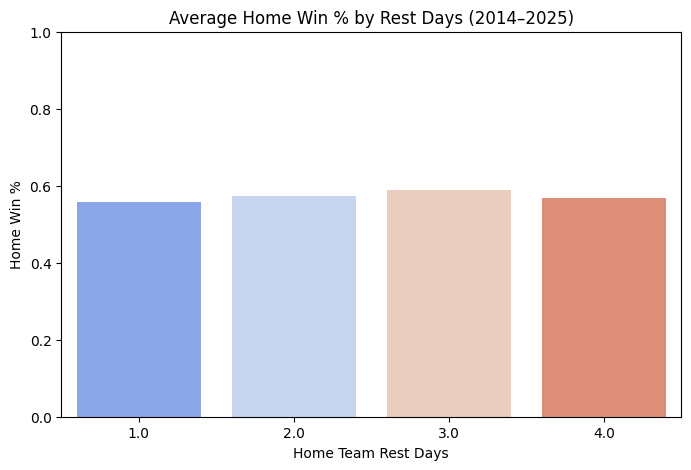

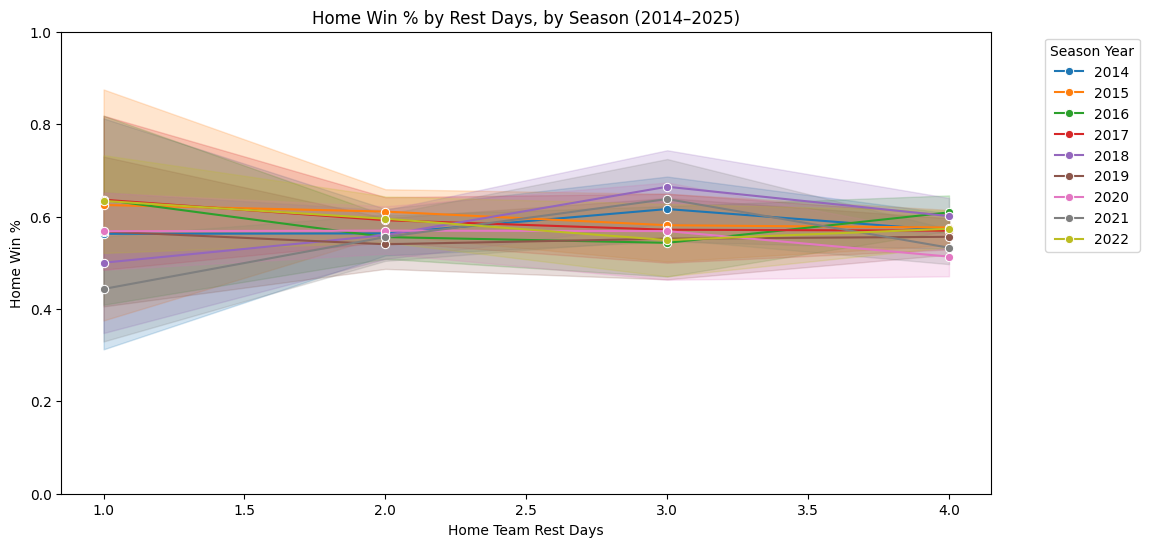

<Axes: xlabel='home_rest_days_limited', ylabel='home_win'>

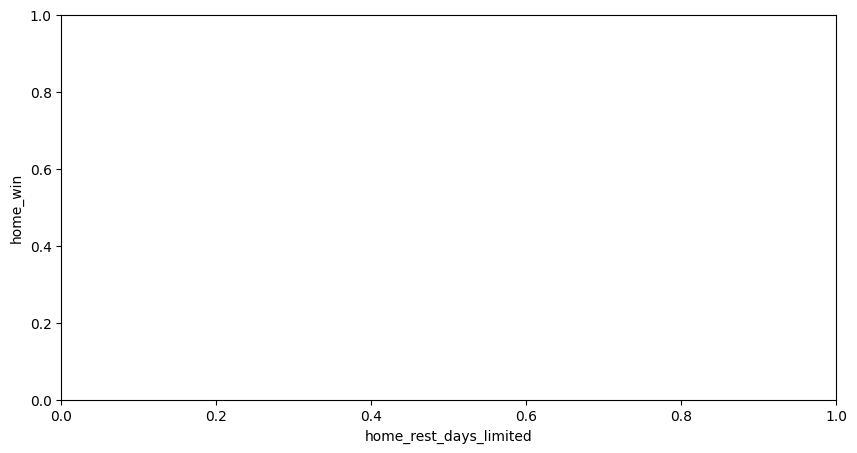

In [ ]:

# -------------------------
# Filter for 2014–2025
# -------------------------
master_df['season_year'] = master_df['season_year'].astype(int)
df_filtered = master_df[(master_df['season_year'] >= 2014) & (master_df['season_year'] <= 2025)]

# Optional: limit rest days to 0–4 for clarity
df_filtered['home_rest_days_limited'] = df_filtered['home_rest_days'].apply(lambda x: x if x <= 4 else 4)


#Average across all seasons

home_rest_avg = df_filtered.groupby('home_rest_days_limited')['home_win'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='home_rest_days_limited', y='home_win', data=home_rest_avg, palette='coolwarm')
plt.title('Average Home Win % by Rest Days (2014–2025)')
plt.xlabel('Home Team Rest Days')
plt.ylabel('Home Win %')
plt.ylim(0,1)
plt.show()


#Break by season
plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_filtered,
    x='home_rest_days_limited',
    y='home_win',
    hue='season_year',
    marker='o',
    palette='tab10'
)
plt.title('Home Win % by Rest Days, by Season (2014–2025)')
plt.xlabel('Home Team Rest Days')
plt.ylabel('Home Win %')
plt.ylim(0,1)
plt.legend(title='Season Year', bbox_to_anchor=(1.05, 1))
plt.show()


# Break by team (example for a few teams)
teams_to_plot = ['Lakers', 'Celtics', 'Warriors']  # pick 3–5 teams
team_summary = df_filtered.groupby(['team_name_home', 'home_rest_days_limited'])['home_win'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(
    data=team_summary[team_summary['team_name_home'].isin(teams_to_plot)],
    x='home_rest_days_limited',
    y='home_win',
    hue='team_name_home',
    marker='o'
)



#Pick Features + EDA of thos Features

In [ ]:
#Filter for 2015-2025 seasons and pick features

df_model = master_df[(master_df['season_year'] >= 2014) & (master_df['season_year'] <= 2025)].copy()

features = [
    "attendance",
    "home_rest_days",
    "away_rest_days",
    "travel_distance_miles",
    "home_back_to_back",
    "away_back_to_back",
    "home_winpct_pregame",
    "away_winpct_pregame"
]

X = df_model[features].fillna(0)
y = df_model["home_win"]  # target: 1 if home team wins, 0 otherwise


In [ ]:
df_model = df_model.sort_values(['home_team_id', 'season_year', 'game_date_est'])

df_model['home_rest_days'] = (
    df_model.groupby(['home_team_id', 'season_year'])['game_date_est']
    .diff()
    .dt.days
)

# clip and fill to clean the small number of NaNs or negatives
df_model['home_rest_days'] = df_model['home_rest_days'].clip(lower=0, upper=10).fillna(7)
df_model['away_rest_days'] = df_model['away_rest_days'].clip(lower=0, upper=10).fillna(7)



In [ ]:
print(df_model['home_rest_days'].describe())
print(df_model['away_rest_days'].describe())


count    10749.000000
mean         4.619779
std          2.794557
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         10.000000
Name: home_rest_days, dtype: float64
count    10749.000000
mean         9.619872
std          1.242349
min          1.000000
25%         10.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: away_rest_days, dtype: float64


In [ ]:
#Check each feature/predictor

df_model[["attendance","home_rest_days","away_rest_days","travel_distance_miles",
             "home_back_to_back","away_back_to_back","home_winpct_pregame","away_winpct_pregame"]].isna().sum()


,0
attendance,1613
home_rest_days,0
away_rest_days,0
travel_distance_miles,0
home_back_to_back,0
away_back_to_back,0
home_winpct_pregame,0
away_winpct_pregame,0


##Feature Distributions

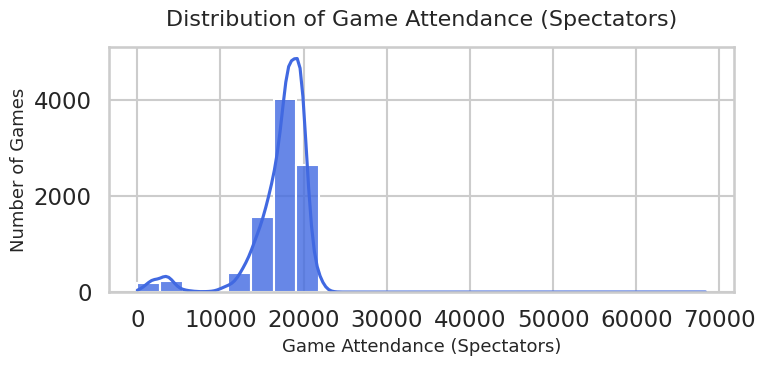

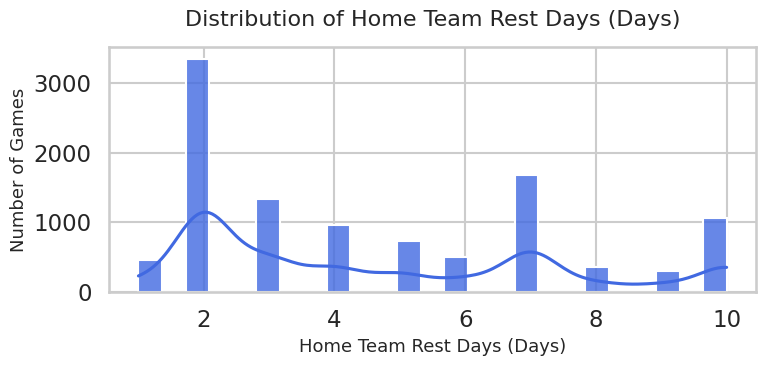

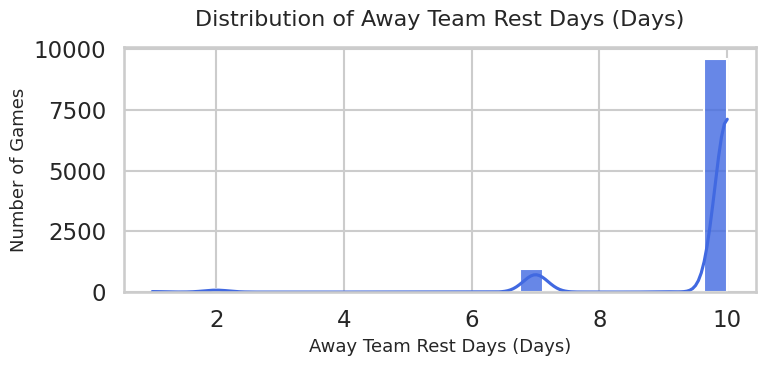

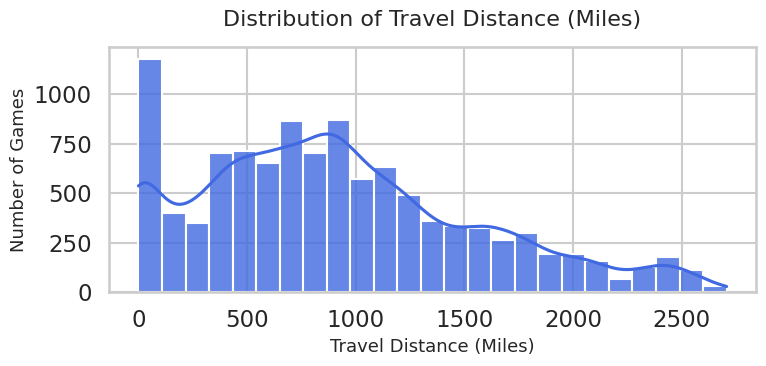

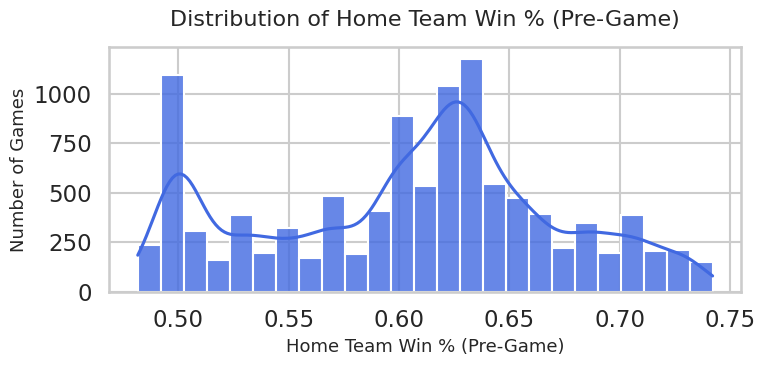

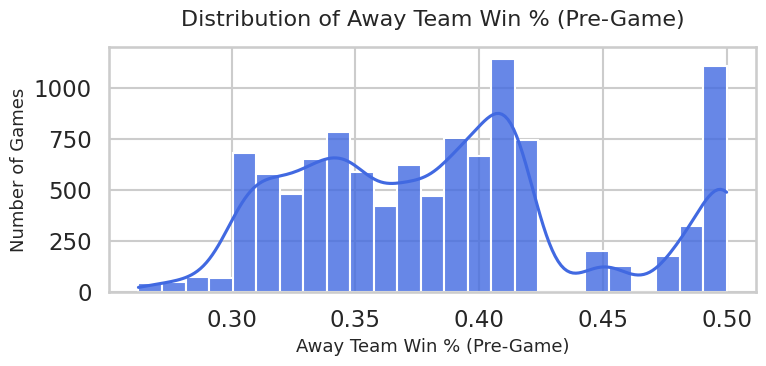

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

# Define predictor columns and readable labels
predictors = {
    "attendance": "Game Attendance (Spectators)",
    "home_rest_days": "Home Team Rest Days (Days)",
    "away_rest_days": "Away Team Rest Days (Days)",
    "travel_distance_miles": "Travel Distance (Miles)",
    "home_winpct_pregame": "Home Team Win % (Pre-Game)",
    "away_winpct_pregame": "Away Team Win % (Pre-Game)"
}

# Loop through and plot each variable
for col, label in predictors.items():
    plt.figure(figsize=(8,4))
    sns.histplot(df_model[col].dropna(), kde=True, bins=25, color='royalblue', edgecolor='white', alpha=0.8)
    plt.title(f"Distribution of {label}", fontsize=16, pad=15)
    plt.xlabel(label, fontsize=13)
    plt.ylabel("Number of Games", fontsize=13)
    plt.tight_layout()
    plt.show()


Optimization terminated successfully.
         Current function value: 0.664550
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               home_win   No. Observations:                65642
Model:                          Logit   Df Residuals:                    65639
Method:                           MLE   Df Model:                            2
Date:                Tue, 14 Oct 2025   Pseudo R-squ.:               8.418e-05
Time:                        22:40:51   Log-Likelihood:                -43622.
converged:                       True   LL-Null:                       -43626.
Covariance Type:            nonrobust   LLR p-value:                   0.02542
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.5329      0.021     25.305      0.000       0.492       0.

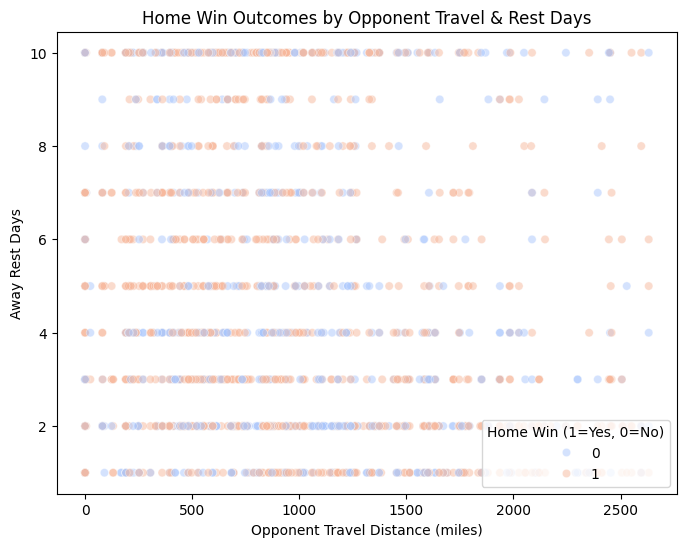

In [ ]:
import statsmodels.api as sm

X = master_df[['travel_distance_miles', 'away_rest_days']]
X = sm.add_constant(X)
y = master_df['home_win']

model2 = sm.Logit(y, X).fit()
print(model2.summary())

# Create smooth 2D visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='travel_distance_miles',
    y='away_rest_days',
    hue='home_win',
    data=master_df.sample(2000, random_state=42),
    palette='coolwarm',
    alpha=0.5
)
plt.title('Home Win Outcomes by Opponent Travel & Rest Days')
plt.xlabel('Opponent Travel Distance (miles)')
plt.ylabel('Away Rest Days')
plt.legend(title='Home Win (1=Yes, 0=No)', loc='lower right')
plt.show()



/tmp/ipython-input-3627034085.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='home_back_to_back', data=df_model, palette='Blues_r', edgecolor='black')


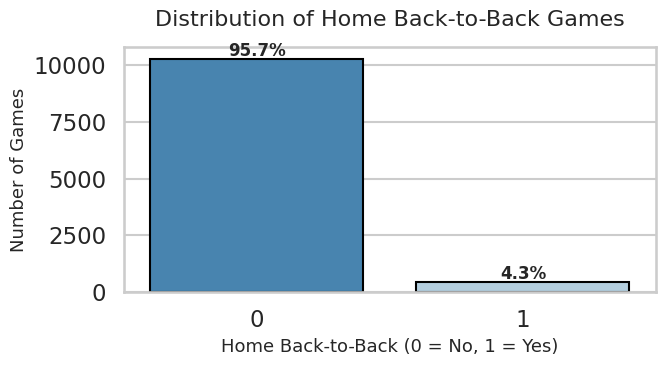

/tmp/ipython-input-3627034085.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='away_back_to_back', data=df_model, palette='Reds_r', edgecolor='black')


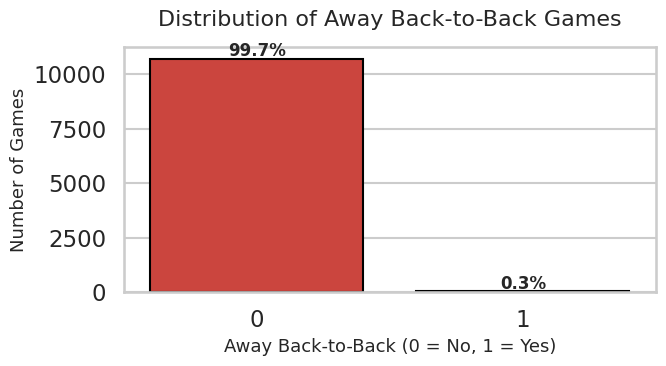

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Apply same visual style as before
sns.set(style="whitegrid", context="talk")

# --- Home Back-to-Back ---
plt.figure(figsize=(7,4))
sns.countplot(x='home_back_to_back', data=df_model, palette='Blues_r', edgecolor='black')
plt.title('Distribution of Home Back-to-Back Games', fontsize=16, pad=15)
plt.xlabel('Home Back-to-Back (0 = No, 1 = Yes)', fontsize=13)
plt.ylabel('Number of Games', fontsize=13)

# Add percentage labels on bars
total = len(df_model)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    plt.text(p.get_x() + p.get_width()/2, p.get_height() + 100, percentage,
             ha='center', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


# --- Away Back-to-Back ---
plt.figure(figsize=(7,4))
sns.countplot(x='away_back_to_back', data=df_model, palette='Reds_r', edgecolor='black')
plt.title('Distribution of Away Back-to-Back Games', fontsize=16, pad=15)
plt.xlabel('Away Back-to-Back (0 = No, 1 = Yes)', fontsize=13)
plt.ylabel('Number of Games', fontsize=13)

# Add percentage labels on bars
total = len(df_model)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    plt.text(p.get_x() + p.get_width()/2, p.get_height() + 100, percentage,
             ha='center', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()



##Statistical Summary of the 6 numerical features

In [ ]:
#Check distributions

df_model[predictors].describe().T


,count,mean,std,min,25%,50%,75%,max
attendance,9136.0,17109.891637,3834.599584,0.000000,16222.500000,18111.000000,19432.000000,68323.000000
home_rest_days,10749.0,4.619779,2.794557,1.000000,2.000000,4.000000,7.000000,10.000000
away_rest_days,10749.0,9.619872,1.242349,1.000000,10.000000,10.000000,10.000000,10.000000
travel_distance_miles,10749.0,917.296235,635.961143,0.000000,442.568600,849.337401,1267.617718,2707.541182
home_winpct_pregame,10749.0,0.605228,0.065651,0.481665,0.553659,0.616896,0.645845,0.742004
away_winpct_pregame,10749.0,0.386076,0.059327,0.262383,0.339115,0.383964,0.414435,0.500000


#Prepare for Logistic Regression

In [ ]:
#Scale continuous predictors so features are on comparable scales
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_model[["attendance", "home_rest_days", "away_rest_days", "travel_distance_miles"]])
scaled_df = pd.DataFrame(scaled_features, columns=["attendance", "home_rest_days", "away_rest_days", "travel_distance_miles"])


In [ ]:
#Reattach binary predictors
df_scaled = pd.concat([
    scaled_df,
    df_model[["home_back_to_back", "away_back_to_back", "home_winpct_pregame", "away_winpct_pregame", "home_win"]].reset_index(drop=True)
], axis=1)


In [ ]:
#Lets see if there is imbalance: DO we have more home wins than losses in the dataset?
df_model['home_win'].value_counts(normalize=True)


,proportion
home_win,
1,0.571588
0,0.428412


/tmp/ipython-input-1209050777.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='home_win', data=df_model, palette='coolwarm')


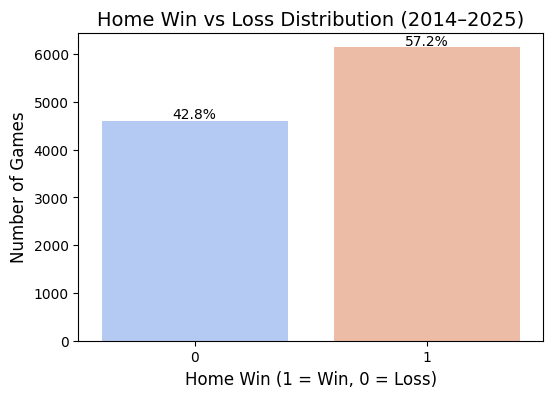

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar chart
plt.figure(figsize=(6,4))
sns.countplot(x='home_win', data=df_model, palette='coolwarm')

# Label formatting
plt.title('Home Win vs Loss Distribution (2014–2025)', fontsize=14)
plt.xlabel('Home Win (1 = Win, 0 = Loss)', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)

# Add percentage labels on bars
total = len(df_model)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    plt.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 50,
        percentage,
        ha='center'
    )

plt.show()


In [ ]:
#This is pretty good, this means that 57% of games in our dataset were home wins, and 42% were home team losses

In [ ]:
#Let us see correlations
df_model[predictors + ['home_win']].corr()['home_win'].sort_values(ascending=False)


,home_win
home_win,1.000000
attendance,0.036391
home_winpct_pregame,0.023430
away_rest_days,0.000834
travel_distance_miles,-0.000356
home_rest_days,-0.008808
away_winpct_pregame,-0.017312


#Logistic Regression

In [ ]:
#Train & Logsitic Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# --- Prepare features and target ---
X = df_scaled.drop(columns="home_win")
y = df_scaled["home_win"]

# Fill missing numeric values with column means
X = X.fillna(X.mean())

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Train logistic regression model ---
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg.fit(X_train, y_train)

print(" Logistic Regression model trained successfully!")



 Logistic Regression model trained successfully!


##Confusion Matrix, Classification, + Feature Importance

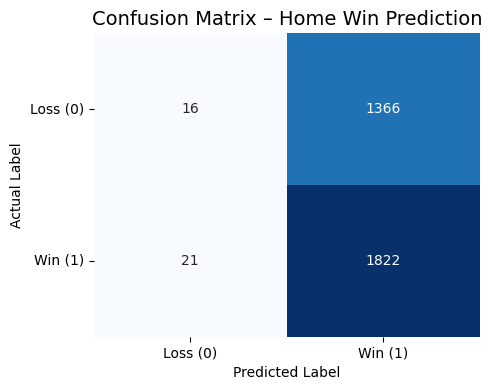

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = log_reg.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix – Home Win Prediction', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.xticks(ticks=[0.5, 1.5], labels=['Loss (0)', 'Win (1)'])
plt.yticks(ticks=[0.5, 1.5], labels=['Loss (0)', 'Win (1)'], rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Loss (0)', 'Win (1)']))


Classification Report:

              precision    recall  f1-score   support

    Loss (0)       0.43      0.01      0.02      1382
     Win (1)       0.57      0.99      0.72      1843

    accuracy                           0.57      3225
   macro avg       0.50      0.50      0.37      3225
weighted avg       0.51      0.57      0.42      3225



In [ ]:
#This model currently predicts “home win” for almost every game, which yields okay accuracy because home teams really do win ~57% of the time, but it’s not distinguishing the tough cases (when home teams lose).

#By balancing classes and improving features (e.g., using differences), we could get a much more meaningful model that explains why home court advantage varies.

/tmp/ipython-input-359985045.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')


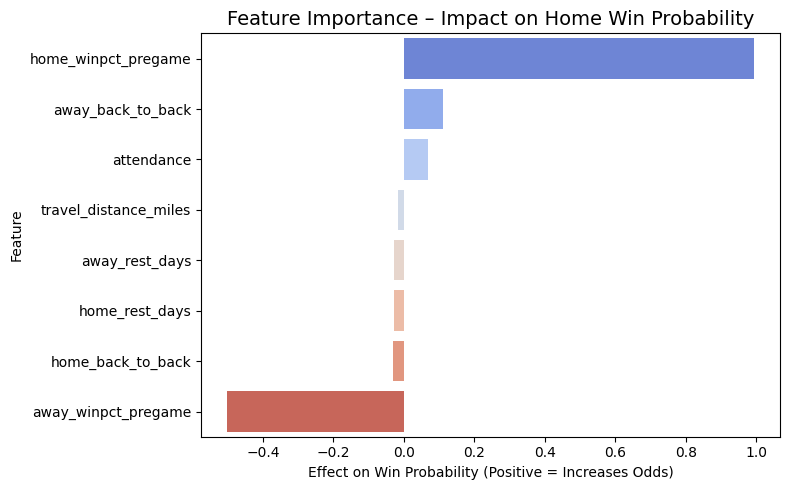

,Feature,Coefficient
6,home_winpct_pregame,0.992224
5,away_back_to_back,0.110860
0,attendance,0.067715
3,travel_distance_miles,-0.015988
2,away_rest_days,-0.028156
1,home_rest_days,-0.028789
4,home_back_to_back,-0.030081
7,away_winpct_pregame,-0.501146


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.title('Feature Importance – Impact on Home Win Probability', fontsize=14)
plt.xlabel('Effect on Win Probability (Positive = Increases Odds)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

coef_df


In [ ]:
#Positive coefficients → increase odds of a home win (e.g., attendance, home rest days).

#Negative coefficients → decrease odds (e.g., away rest days, long travel distance).

#The bar length shows relative importance.#

#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  # helps fix imbalance
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.41      0.47      0.44      7583
           1       0.63      0.58      0.61     12110

    accuracy                           0.54     19693
   macro avg       0.52      0.52      0.52     19693
weighted avg       0.55      0.54      0.54     19693



/tmp/ipython-input-752777384.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='coolwarm')


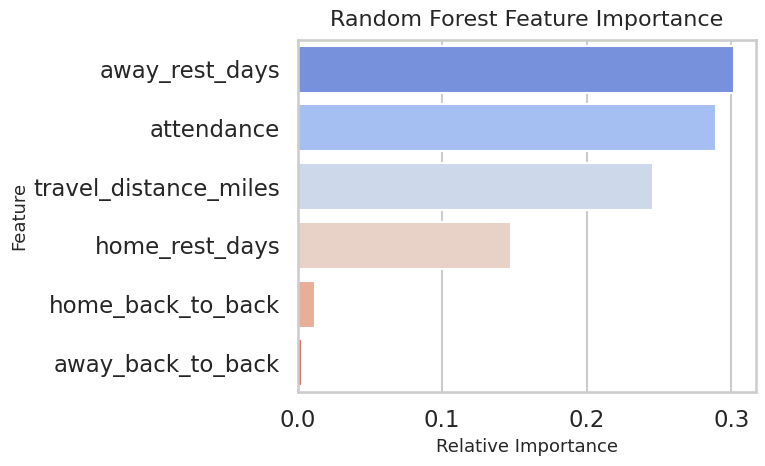

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use X_train.columns from the model training step
features = X_train.columns
importances = rf.feature_importances_

# Combine safely into a DataFrame
feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='coolwarm')
plt.title('Random Forest Feature Importance', fontsize=16, pad=10)
plt.xlabel('Relative Importance', fontsize=13)
plt.ylabel('Feature', fontsize=13)
plt.tight_layout()
plt.show()


#0

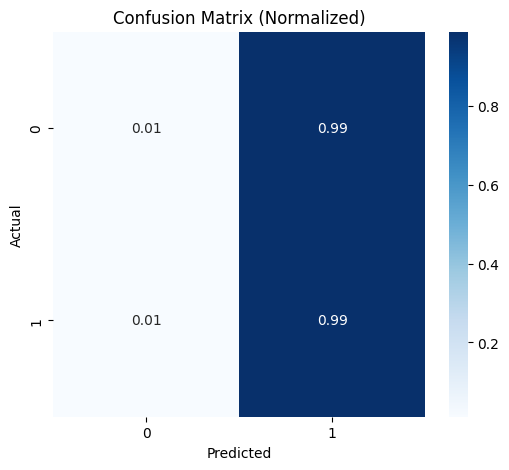

              precision    recall  f1-score   support

           0       0.43      0.01      0.02      1382
           1       0.57      0.99      0.72      1843

    accuracy                           0.57      3225
   macro avg       0.50      0.50      0.37      3225
weighted avg       0.51      0.57      0.42      3225



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))


In [ ]:
#Interpret coefficients
#Positive coefficients mean the variable increases home win probability; negative means it decreases it.

import numpy as np
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_[0],
    "Abs_Coefficient": np.abs(model.coef_[0])
}).sort_values("Abs_Coefficient", ascending=False)

print(coef_df)


                 Feature  Coefficient  Abs_Coefficient
5      away_back_to_back     0.519455         0.519455
4      home_back_to_back    -0.061563         0.061563
0             attendance     0.055985         0.055985
6    home_winpct_pregame     0.043261         0.043261
2         away_rest_days     0.017135         0.017135
7    away_winpct_pregame     0.005484         0.005484
1         home_rest_days     0.005394         0.005394
3  travel_distance_miles     0.000000         0.000000


# Filtering for years 2014-2025

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

games_df['game_date'] = pd.to_datetime(games_df['game_date'])
games_df = games_df.dropna(subset=['wl_home', 'wl_away'])

# Convert wl_home to binary target variable
games_df['wl_home_binary'] = games_df['wl_home'].apply(lambda x: 1 if x == 'W' else 0)

# features and target
X = games_df[['pts_home', 'pts_away']]
y = games_df['wl_home_binary']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 1.0
Confusion Matrix:
[[5083    0]
 [   0 8057]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5083
           1       1.00      1.00      1.00      8057

    accuracy                           1.00     13140
   macro avg       1.00      1.00      1.00     13140
weighted avg       1.00      1.00      1.00     13140



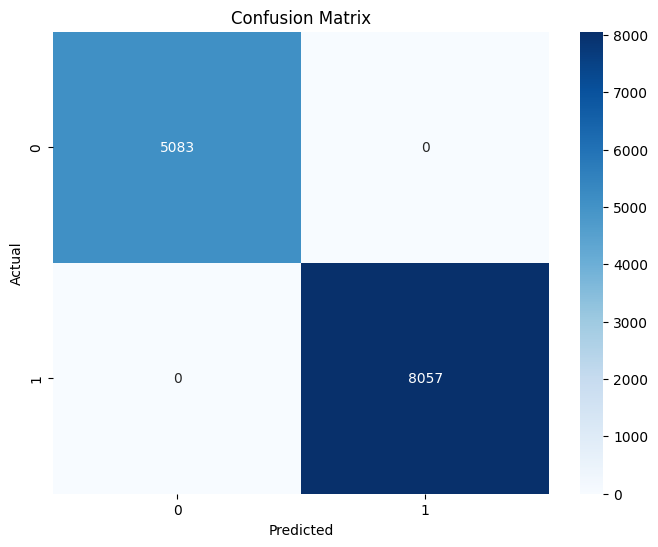

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# 1. Define X and y
features = ["attendance", "home_rest_days", "away_rest_days", "home_back_to_back", "away_back_to_back", "travel_distance_miles"]
X = master_df[features].fillna(0)  # simple fill for now
y = master_df["home_win"].astype(int)

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Fit logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Predict and evaluate
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[    3  7580]
 [    0 12110]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      7583
           1       0.62      1.00      0.76     12110

    accuracy                           0.62     19693
   macro avg       0.81      0.50      0.38     19693
weighted avg       0.76      0.62      0.47     19693



In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

for model in [rf, gb]:
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f'{model.__class__.__name__} Average Accuracy:', scores.mean())


RandomForestClassifier Average Accuracy: 0.5581337342581273
GradientBoostingClassifier Average Accuracy: 0.6093809627514234
